In [ ]:
!pip install utils

In [ ]:
!pip install mxnet

In [ ]:
from utils import *

import time
import numpy as np

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score


In [ ]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

In [ ]:
def parser(x):
    return datetime.datetime.strptime(x,'%d-%m-%Y')

In [ ]:
import pandas as pd
dataset_ex_df = pd.read_csv('GS.csv', header=0, parse_dates=[0], date_parser=parser)


In [ ]:
dataset_ex_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,JPM,MS
0,2001-07-09,82.599998,82.900002,81.250000,81.910004,64.095253,2765400,43.990002,60.730000
1,2001-07-10,82.250000,82.849998,81.139999,81.599998,63.852703,2444600,42.009998,58.459999
2,2001-07-11,81.250000,81.949997,80.000000,81.599998,63.852703,2863700,42.049999,57.820000
3,2001-07-12,83.500000,86.849998,83.080002,86.550003,67.726112,3151600,42.540001,61.820000
4,2001-07-13,86.000000,88.000000,85.620003,86.150002,67.413109,1880300,42.549999,61.419998


In [ ]:
dataset_ex_df[['Date', 'Open']].head(3)

,Date,Open
0,2001-07-09,82.599998
1,2001-07-10,82.250000
2,2001-07-11,81.250000


In [ ]:
print('There are {} days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 5030 days in the dataset.


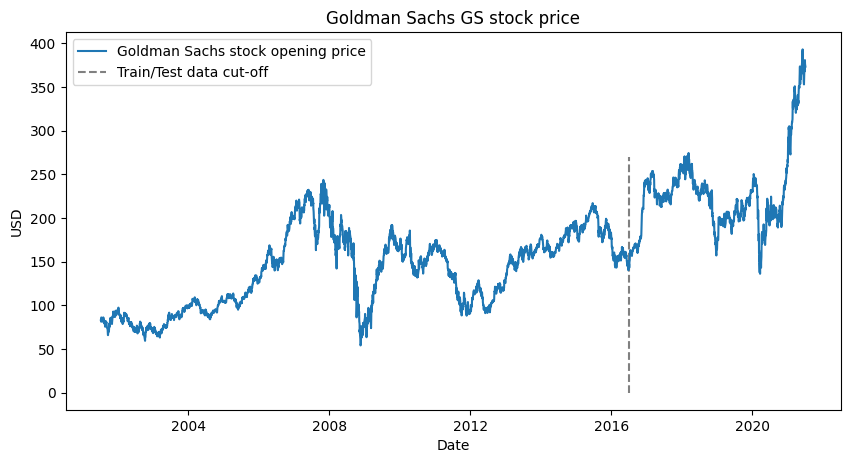

In [ ]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['Open'], label='Goldman Sachs stock opening price')
plt.vlines(datetime.date(2016,7,6), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Goldman Sachs GS stock price')
plt.legend()
plt.show()

In [ ]:
dataset_ex_df.shape

(5030, 9)

In [ ]:
num_training_days=dataset_ex_df.shape[0]*.8

In [ ]:
num_test_days=dataset_ex_df.shape[0]*.2

In [ ]:
print(num_training_days)

4024.0


In [ ]:
print(num_test_days)

1006.0


In [ ]:
pip install universal-portfolios

In [ ]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['price'].rolling(window=7).mean()
    dataset['ma21'] = dataset['price'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['price'].ewm(span=26).mean()
    dataset['12ema'] = dataset['price'].ewm( span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset['price'].rolling(window=20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['price'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['price']-1
    
    return dataset

In [ ]:
(dataset_ex_df[['Open']])

,Open
0,82.599998
1,82.250000
2,81.250000
3,83.500000
4,86.000000
...,...
5025,374.859985
5026,370.899994
5027,380.700012
5028,376.309998


In [ ]:
dataset_ex_df.rename(columns = {'Open':'price'}, inplace = True)

In [ ]:
(dataset_ex_df[['price']])

,price
0,82.599998
1,82.250000
2,81.250000
3,83.500000
4,86.000000
...,...
5025,374.859985
5026,370.899994
5027,380.700012
5028,376.309998


In [ ]:
dataset_ex_df.head()

,Date,price,High,Low,Close,Adj Close,Volume,JPM,MS
0,2001-07-09,82.599998,82.900002,81.250000,81.910004,64.095253,2765400,43.990002,60.730000
1,2001-07-10,82.250000,82.849998,81.139999,81.599998,63.852703,2444600,42.009998,58.459999
2,2001-07-11,81.250000,81.949997,80.000000,81.599998,63.852703,2863700,42.049999,57.820000
3,2001-07-12,83.500000,86.849998,83.080002,86.550003,67.726112,3151600,42.540001,61.820000
4,2001-07-13,86.000000,88.000000,85.620003,86.150002,67.413109,1880300,42.549999,61.419998


In [ ]:
dataset_TI_df = get_technical_indicators(dataset_ex_df[['price']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [ ]:
dataset_TI_df.head(21)

,price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,82.599998,NaN,NaN,82.599998,82.599998,0.000000,NaN,NaN,NaN,82.599998,81.599998
1,82.250000,NaN,NaN,82.418268,82.410416,-0.007853,NaN,NaN,NaN,82.337499,81.250000
2,81.250000,NaN,NaN,81.998521,81.957505,-0.041016,NaN,NaN,NaN,81.584615,80.250000
3,83.500000,NaN,NaN,82.418269,82.444411,0.026142,NaN,NaN,NaN,82.877500,82.500000
4,86.000000,NaN,NaN,83.248887,83.410451,0.161564,NaN,NaN,NaN,84.967769,85.000000
5,85.900002,NaN,NaN,83.779884,84.015543,0.235659,NaN,NaN,NaN,85.590111,84.900002
6,82.900002,83.485715,NaN,83.623402,83.766614,0.143212,NaN,NaN,NaN,83.795885,81.900002
7,83.849998,83.664286,NaN,83.659912,83.784015,0.124103,NaN,NaN,NaN,83.831966,82.849998
8,85.000000,84.057143,NaN,83.858542,84.024580,0.166038,NaN,NaN,NaN,84.610695,84.000000
9,82.849998,84.285714,NaN,83.719373,83.801997,0.082624,NaN,NaN,NaN,83.436877,81.849998


In [ ]:
dataset_TI_df.tail(20)

,price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
5010,385.790009,383.392857,371.036191,368.697382,378.650828,9.953446,11.041158,393.118507,348.953875,387.530510,384.790009
5011,383.160004,384.987144,371.496191,369.768687,379.344547,9.575860,11.199832,393.895855,349.096527,384.616839,382.160004
5012,389.640015,386.692858,372.764763,371.240637,380.928465,9.687828,11.661032,396.086827,349.442700,387.965623,388.640015
5013,375.700012,385.602862,373.366192,371.570961,380.124088,8.553126,10.673229,394.712649,352.019735,379.788549,374.700012
5014,377.429993,384.914289,374.517620,372.004964,379.709612,7.704648,10.282379,395.082378,353.952863,378.216178,376.429993
5015,373.500000,382.602862,375.065239,372.115707,378.754287,6.638580,10.145424,395.356088,354.774391,375.072059,372.500000
5016,370.989990,379.458575,375.218096,372.032321,377.559780,5.527459,10.153989,395.526074,354.910119,372.350680,369.989990
5017,373.519989,377.705715,375.320000,372.142518,376.938273,4.795755,9.503270,394.326541,356.313460,373.130219,372.519989
5018,356.519989,373.899998,375.154285,370.985294,373.796999,2.811705,9.749068,394.652421,355.656150,362.056732,355.519989
5019,352.890015,368.649998,374.864286,369.644903,370.580540,0.935637,10.575639,396.015564,353.713007,355.945587,351.890015


In [ ]:
dataset_TI_df=dataset_TI_df.drop(dataset_TI_df.index[range(19)],axis=0)

In [ ]:
dataset_TI_df=dataset_TI_df.drop(labels=[19],axis=0)

In [ ]:
dataset_TI_df.reset_index()

,index,price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,20,84.849998,84.459998,83.672380,83.908415,84.210342,0.301928,1.546028,86.764436,80.580324,85.152065,83.849998
1,21,83.680000,84.339998,83.723809,83.887681,84.126629,0.238948,1.506742,86.737293,80.710325,84.170688,82.680000
2,22,82.900002,84.204285,83.754761,83.799502,83.933782,0.134280,1.401405,86.557571,80.951952,83.323564,81.900002
3,23,80.599998,83.939999,83.723809,83.518129,83.411413,-0.106716,1.581277,86.886362,80.561256,81.507853,79.599998
4,24,79.809998,83.412856,83.548095,83.196487,82.848709,-0.347778,1.714764,86.977622,80.118567,80.375950,78.809998
...,...,...,...,...,...,...,...,...,...,...,...,...
5005,5025,374.859985,363.308572,374.065238,368.233058,368.140376,-0.092682,11.947155,397.959547,350.170929,372.343644,373.859985
5006,5026,370.899994,365.881426,373.741428,368.430609,368.564933,0.134324,11.751585,397.244599,350.238257,371.381211,369.899994
5007,5027,380.700012,369.267142,373.616191,369.339454,370.431868,1.092415,11.694162,397.004515,350.227866,377.593745,379.700012
5008,5028,376.309998,371.769998,373.333333,369.855790,371.336196,1.480406,11.066890,395.467113,351.199554,376.737914,375.309998


In [ ]:
dataset_TI_df['log_momentum'] = np.log(dataset_TI_df['momentum'])

In [ ]:
dataset_TI_df.head()

,price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
20,84.849998,84.459998,83.672380,83.908415,84.210342,0.301928,1.546028,86.764436,80.580324,85.152065,83.849998,4.429029
21,83.680000,84.339998,83.723809,83.887681,84.126629,0.238948,1.506742,86.737293,80.710325,84.170688,82.680000,4.414978
22,82.900002,84.204285,83.754761,83.799502,83.933782,0.134280,1.401405,86.557571,80.951952,83.323564,81.900002,4.405499
23,80.599998,83.939999,83.723809,83.518129,83.411413,-0.106716,1.581277,86.886362,80.561256,81.507853,79.599998,4.377014
24,79.809998,83.412856,83.548095,83.196487,82.848709,-0.347778,1.714764,86.977622,80.118567,80.375950,78.809998,4.367040


In [ ]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['price'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

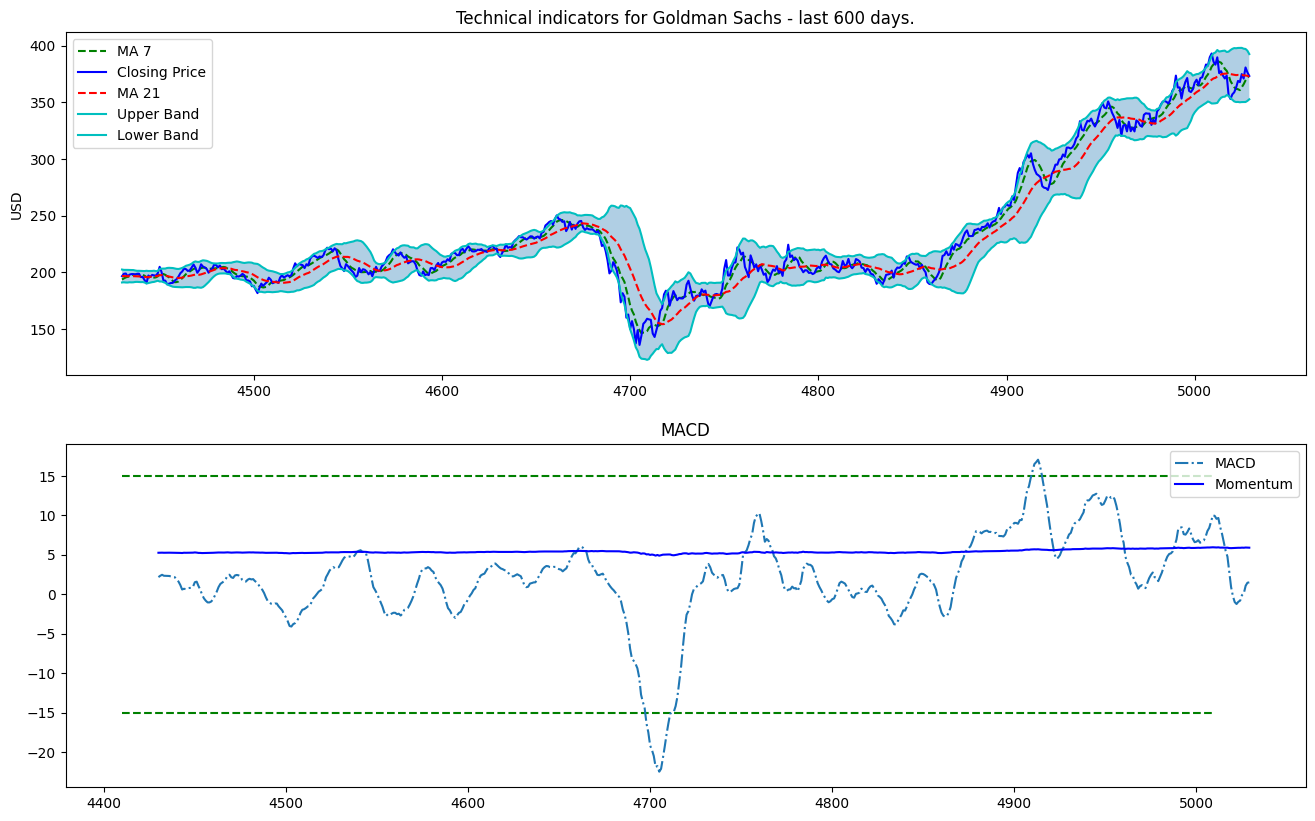

In [ ]:
plot_technical_indicators(dataset_TI_df, 600)

# **Sentiment Analysis**


In [ ]:
pip install bert

  Created wheel for bert: filename=bert-2.2.0-cp37-none-any.whl size=3767 sha256=370e5a928b473fa6c765929e855fb91fd61c7e01940ad48aa9e7e5492ac0ab8d
  Stored in directory: /root/.cache/pip/wheels/fe/71/b7/941459453bd38e5d97a8c886361dee19325e9933c9cf88ad46
  Created wheel for erlastic: filename=erlastic-2.0.0-cp37-none-any.whl size=6795 sha256=c417fbc76d3220c2ab6213bd9f8ca0180915c92a8a24e342c6f84e19fcb20707
  Stored in directory: /root/.cache/pip/wheels/02/62/46/93c713a5f061aeeb4f16eb6bf5ee798816e6ddda70faa78e69
Successfully built bert erlastic


In [ ]:
data_FT = dataset_ex_df[['Date', 'price']]

In [ ]:
close_fft = np.fft.fft(np.asarray(data_FT['price'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


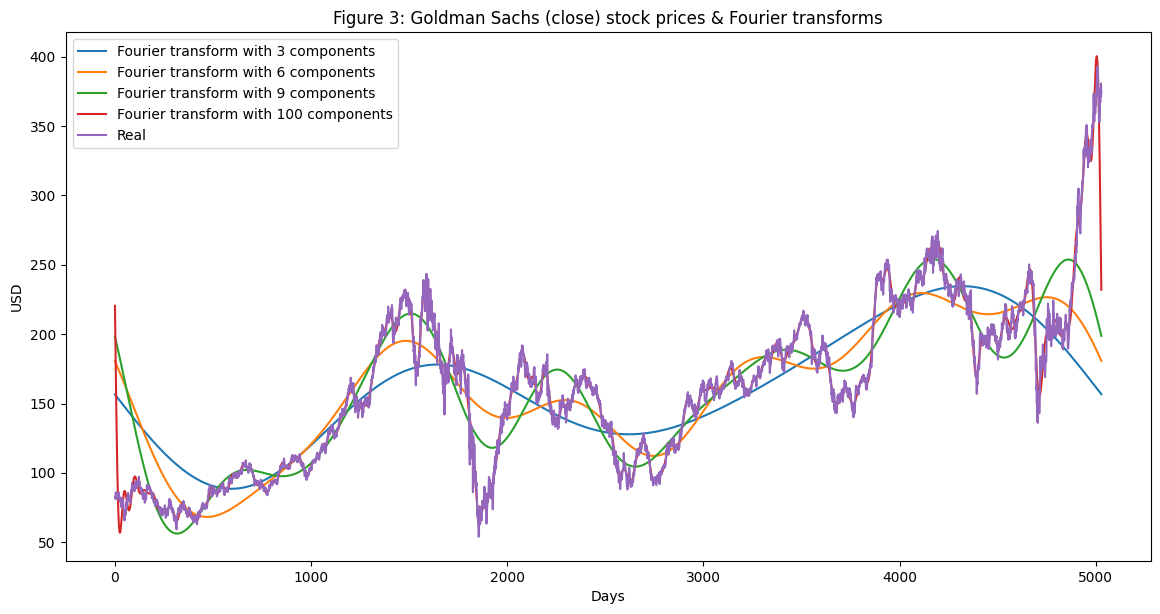

In [ ]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['price'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

ARIMA


In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['price']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsm

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                 5029
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -13167.565
Method:                       css-mle   S.D. of innovations              3.318
Date:                Sat, 10 Jul 2021   AIC                          26349.130
Time:                        13:00:50   BIC                          26394.791
Sample:                             1   HQIC                         26365.129
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0579      0.043      1.344      0.179      -0.027       0.142
ar.L1.D.price    -0.0758      0.014     -5.375      0.000      -0.103      -0.048
ar.L2.D.price    -0.0114      0.014     

In [ ]:
pip install pandas.tools

ERROR: Could not find a version that satisfies the requirement pandas.tools (from versions: none)
ERROR: No matching distribution found for pandas.tools


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/misc.py:411: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


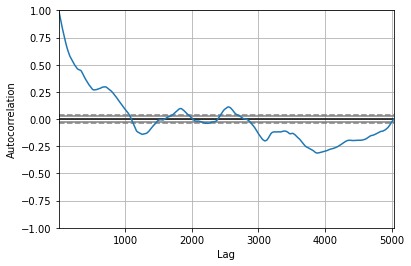

<Figure size 800x560 with 0 Axes>

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [ ]:
import sklearn

In [ ]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [ ]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 13.740


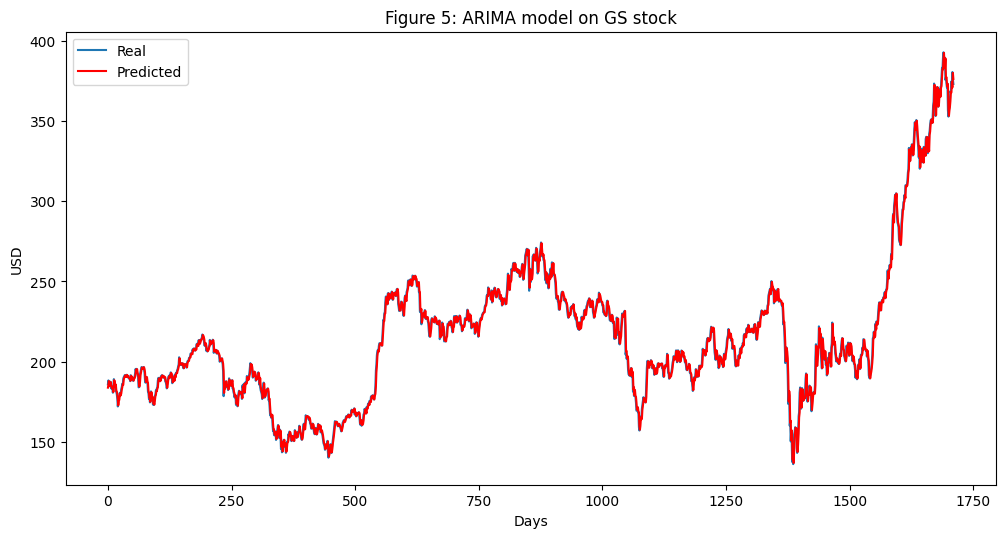

In [ ]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on GS stock')
plt.legend()
plt.show()

In [ ]:
dataset_total_df=

SyntaxError: ignored

In [ ]:
print('Total dataset has {} samples, and {} features.'.format(dataset_total_df.shape[0], \
                                                              dataset_total_df.shape[1]))